# Fused Layers in Triton

## Setup

In [1]:
%pip install --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly==3.0.0.post20240626041721

Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"
os.environ["DISABLE_TORCH_COMPILE"] = "true"
os.environ["TRITON_PRINT_AUTOTUNING"] = "1"

Check the installed triton version.

In [3]:
import triton

assert triton.__version__ == "3.0.0", f"Expected Triton to have a version of 3.0.0, but found {triton.__version__}"

Import other needed stuff.

In [4]:
import torch
import triton.language as tl

## Generic Autotune Config

In [5]:
def get_autotune_config():
    return [
        triton.Config({}, num_warps=1),
        triton.Config({}, num_warps=2),
        triton.Config({}, num_warps=4),
        triton.Config({}, num_warps=8),
        triton.Config({}, num_warps=16),
        triton.Config({}, num_warps=32),
    ]

## 2D Fused Layer Norm with Quantization

We want to fuse the RMSNorm and the quantization into one layer.

Recall that the RMSNorm is defined to be
$$
\frac{\mathbf{X}}{\mathrm{RMS}(\mathbf{X})}\odot \mathbf{G} + \mathbf{B}
$$
where $\mathbf{X}$ is the input tensor, $\mathbf{G}$ is the 'gain' tensor (gamma in the original LayerNorm paper), and $\mathbf{B}$ is the bias tensor.

### Baseline Specification

Define the spec that we will be implementing in Triton.

In [6]:
def quant_rms_norm_baseline(x: torch.Tensor, gain, bias, epsilon):
    dim = x.shape[-1]
    scale = dim**0.5

    x_norm = torch.nn.functional.normalize(x, p=2, eps=1e-5, dim=-1) * scale
    if gain is not None:
        x_norm *= gain
    if bias is not None:
        x_norm += bias

    scale = 127.0 / torch.unsqueeze(torch.max(torch.abs(x_norm), dim=-1).values.clamp_(epsilon), -1)
    y = torch.clip(torch.round(x_norm * scale), -128, 127) / scale

    return x_norm + (y - x_norm).detach()

### Forward Pass

First define the kernel.

In [7]:
# ruff: noqa: N803
@triton.autotune(
    configs=get_autotune_config(),
    key=["N", "HAS_GAIN", "HAS_BIAS"],
)
@triton.jit
def quant_rms_norm_fwd_kernel(
    # fmt: off
    # Pointers to arrays
    x_ptr, y_ptr, gain_ptr, bias_ptr, rrms_ptr,
    # Strides
    stride_x_row,  # How much to increase the pointer when moving by 1 row
    stride_y_row,
    # Some constants
    N,        # Number of columns in X
    EPSILON,  # To avoid division by zero
    # Meta-parameters
    BLOCK_SIZE_N: tl.constexpr,
    HAS_GAIN: tl.constexpr,
    HAS_BIAS: tl.constexpr
    # fmt: on
):
    """
    Forward kernel.

    Performs RMSNorm on ``X``, followed by 8-bit quantization.
    """

    # Map the PID to the row of X that should be loaded
    pid = tl.program_id(0)
    x_ptr += pid * stride_x_row

    offsets = tl.arange(0, BLOCK_SIZE_N)
    mask = offsets < N
    x = tl.load(x_ptr + offsets, mask=mask, other=0.0).to(tl.float32)  # Load in higher precision

    # Compute reciprocal root mean square (rrms)
    mean_of_squares = tl.sum(x * x, axis=0) / N
    rrms = 1 / tl.sqrt(mean_of_squares + EPSILON)
    tl.store(rrms_ptr + pid, rrms)  # We add PID since that is the row that the RRMS is corresponding to

    # Normalize
    x_hat = x * rrms

    # Apply gain and bias
    y = x_hat

    if HAS_GAIN:
        gain = tl.load(gain_ptr + offsets, mask=mask).to(tl.float32)
        y = y * gain
    if HAS_BIAS:
        bias = tl.load(bias_ptr + offsets, mask=mask).to(tl.float32)
        y = y + bias

    # Apply 8-bit quantization
    scale = 127.0 / tl.maximum(tl.max(tl.abs(y), 0), EPSILON)
    y = tl.extra.cuda.libdevice.round(y * scale)  # TODO: This is CUDA only... can we generalize this?
    y = tl.maximum(tl.minimum(y, 127), -128) / scale  # The nested max and min creates the clamp/clip function

    # Write output
    y_ptr += pid * stride_y_row
    tl.store(y_ptr + offsets, y, mask=mask)

Then define the companion function that handles checking and allocation of tensors.

In [8]:
# ruff: noqa: N806, S101
def quant_rms_norm_fwd(x: torch.Tensor, gain, bias, epsilon):
    """
    Forward pass.

    Performs RMSNorm on ``X``, followed by 8-bit quantization.

    Requires CUDA.
    """

    assert x.ndim == 2  # TODO: Support other ndim values?

    # Get dimensions
    M, N = x.shape

    # Validate that the input is OK
    assert x.stride(-1) == 1

    if gain is not None:
        assert gain.shape == (N,)
        assert gain.stride(-1) == 1
    if bias is not None:
        assert bias.shape == (N,)
        assert bias.stride(-1) == 1

    # Enqueue fused kernel if less than 64KiB per feature
    MAX_FUSED_SIZE = 65536 // x.element_size()
    BLOCK_SIZE_N = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
    if N > BLOCK_SIZE_N:
        raise RuntimeError("This layer norm doesn't support feature dim >= 64KiB.")

    # Allocate output
    y = torch.empty_like(x, dtype=x.dtype)
    rstd = torch.empty((M,), dtype=torch.float32, device="cuda")

    # Run the kernel
    with torch.cuda.device(x.device.index):
        quant_rms_norm_fwd_kernel[(M,)](
            # fmt: off
            # Pointers to arrays
            x, y, gain, bias, rstd,
            # Strides
            x.stride(0),
            y.stride(0),
            # Some constants
            N,  # Number of columns in X
            epsilon,  # To avoid division by zero
            # Meta-parameters
            BLOCK_SIZE_N,
            gain is not None,
            bias is not None
            # fmt: on
        )

    # Return stuff
    return y, rstd

### Backward Pass

The backward pass of the raw RMSNorm layer is a little more involved than the forward pass.

Define $\nabla_\mathbf{Y}$ to be the gradient of the outputs (i.e., Vector-Jacobian Products (VJP), error signal, or $\mathrm{d}\,\mathrm{out}$), $\nabla_\mathbf{X}$ be the required change of $\mathbf{X}$, and $\nabla_\mathbf{G}$ and $\nabla_\mathbf{B}$ be defined similarly. Let $\mathbf{\hat{X}} = \frac{\mathbf{X}}{\mathrm{RMS}(\mathbf{X})}$. Then we have

$$
\begin{align*}
    \nabla_\mathbf{X} &= \frac1{\mathrm{RMS}(\mathbf{X})} \left(\nabla_\mathbf{Y} \odot \mathbf{G} - \underbrace{\left(\frac1N \mathbf{\hat{X}} \cdot \left(\nabla_\mathbf{Y} \odot \mathbf{G} \right) \right)}_{\texttt{intermediate\_const}} \odot \mathbf{\hat{X}}\right) \\
    \nabla_\mathbf{G} &= \sum_{i=1}^{N}\left(\nabla_\mathbf{Y} \odot \mathbf{\hat{X}}\right) & (\text{sum across rows})\\
    \nabla_\mathbf{B} &= \sum_{i=1}^{N}\nabla_\mathbf{Y} & (\text{sum across rows})
\end{align*}
$$

First define the kernel.

In [9]:
# ruff: noqa: N803
@triton.autotune(
    configs=get_autotune_config(),
    key=["N", "HAS_GAIN", "HAS_BIAS"],
)
@triton.jit
def quant_rms_norm_bwd_kernel(
    # fmt: off
    # Gradient inputs
    grad_output_ptr, dx_ptr, dg_ptr, db_ptr,
    # Original inputs
    x_ptr, gain_ptr, rrms_ptr,
    # Strides
    stride_x_row,  # How much to increase the pointer when moving by 1 row
    stride_grad_output_row,
    stride_dx_row,
    # Some constants
    M,                 # Number of rows in X
    N,                 # Number of columns in X
    ROWS_PER_PROGRAM,  # Number of rows of X to compute per program
    # Meta-parameters
    BLOCK_SIZE_N: tl.constexpr,
    HAS_GAIN: tl.constexpr,
    HAS_BIAS: tl.constexpr
    # fmt: on
):
    """
    Backward kernel.

    Performs the backward pass of RMSNorm, skipping the quantization step.
    """

    # Map the PID to the elements of `x`, `dx`, `dg`, and `db` that should be computed
    pid = tl.program_id(0)
    row_start = pid * ROWS_PER_PROGRAM

    x_ptr += row_start * stride_x_row
    grad_output_ptr += row_start * stride_grad_output_row
    dx_ptr += row_start * stride_dx_row

    offsets = tl.arange(0, BLOCK_SIZE_N)
    mask = offsets < N

    # Load gradient array, and prepare gradient and bias output gradient arrays
    if HAS_GAIN:
        gain = tl.load(gain_ptr + offsets, mask=mask).to(tl.float32)
        dg = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)
    if HAS_BIAS:
        db = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)

    # Iterate through the rows
    row_end = min(row_start + ROWS_PER_PROGRAM, M)
    for row in range(row_start, row_end):
        # Load data to SRAM
        x = tl.load(x_ptr + offsets, mask=mask, other=0.0).to(tl.float32)  # Load in higher precision
        grad_output = tl.load(grad_output_ptr + offsets, mask=mask, other=0.0).to(tl.float32)
        rrms = tl.load(rrms_ptr + row)  # Load the reciprocal root mean square (rrms)

        # Compute `x_hat` and the product of the gradient output with the gain
        x_hat = x * rrms

        # Apply contributions to the gain and bias gradients
        gradient_gain_product = grad_output
        if HAS_GAIN:
            gradient_gain_product = grad_output * gain
            dg += grad_output * x_hat
        if HAS_BIAS:
            db += grad_output

        # Compute `dx`
        intermediate_const = tl.sum(x_hat * gradient_gain_product, axis=0) / N
        dx = (gradient_gain_product - x_hat * intermediate_const) * rrms

        # Write `dx`
        tl.store(dx_ptr + offsets, dx, mask=mask)

        # Update pointers to move to next row
        x_ptr += stride_x_row
        grad_output_ptr += stride_grad_output_row
        dx_ptr += stride_dx_row

    # Once we finished computing all the rows for this program, we can write the final `dg` and `db`
    if HAS_GAIN:
        tl.store(dg_ptr + pid * N + offsets, dg, mask=mask)
    if HAS_BIAS:
        tl.store(db_ptr + pid * N + offsets, db, mask=mask)

Then define the companion function that handles checking and allocation of tensors.

In [10]:
# ruff: noqa: N806, S101
import math


def quant_rms_norm_bwd(grad_output: torch.Tensor, x: torch.Tensor, gain, bias, rrms):
    """
    Forward pass.

    Performs RMSNorm on ``X``, followed by 8-bit quantization.

    Requires CUDA.
    """

    assert x.ndim == 2  # TODO: Support other ndim values?

    # Get dimensions
    M, N = x.shape

    # Validate that the input is OK
    assert x.stride(-1) == 1
    assert grad_output.shape == (M, N)
    assert grad_output.stride(-1) == 1

    if gain is not None:
        assert gain.shape == (N,)
        assert gain.stride(-1) == 1
    if bias is not None:
        assert bias.shape == (N,)
        assert bias.stride(-1) == 1

    # Enqueue fused kernel if less than 64KiB per feature
    MAX_FUSED_SIZE = 65536 // x.element_size()
    BLOCK_SIZE_N = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
    if N > BLOCK_SIZE_N:
        raise RuntimeError("This layer norm doesn't support feature dim >= 64KiB.")

    # Allocate output
    multi_processor_count = torch.cuda.get_device_properties(x.device).multi_processor_count

    dx = torch.empty_like(x, dtype=x.dtype)
    if gain is not None:
        # This is temporary as we still need to sum across the rows later
        dg_temp = torch.empty((multi_processor_count, N), dtype=torch.float32, device=gain.device)
    else:
        dg_temp = None
    if bias is not None:
        db_temp = torch.empty((multi_processor_count, N), dtype=torch.float32, device=bias.device)
    else:
        db_temp = None

    # Run the kernel
    # TODO: We could make this faster by using a technique like shown in
    #   https://triton-lang.org/main/getting-started/tutorials/05-layer-norm.html#backward-pass
    rows_per_program = math.ceil(M / multi_processor_count)
    with torch.cuda.device(x.device.index):
        quant_rms_norm_bwd_kernel[(multi_processor_count,)](
            # fmt: off
            # Gradient inputs
            grad_output, dx, dg_temp, db_temp,
            # Original inputs
            x, gain, rrms,
            # Strides
            x.stride(0),
            grad_output.stride(0),
            dx.stride(0),
            # Some constants
            M,
            N,
            rows_per_program,
            # Meta-parameters
            BLOCK_SIZE_N,
            gain is not None,
            bias is not None
            # fmt: on
        )

    # Fix the summing of `dg` and `db`
    if gain is not None:
        dg = dg_temp.sum(0).to(gain.dtype)
    else:
        dg = None

    if bias is not None:
        db = db_temp.sum(0).to(bias.dtype)
    else:
        db = None

    # Return stuff
    return dx, dg, db

### Making the Autograd Function

Since we now have both the forward and backward pass, we can make a `torch.autograd.Function` that comprises both the forward and backward passes.

In [11]:
class QuantRMSNormFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, gain, bias, epsilon=1e-5):
        # Run the forward function
        y, rrms = quant_rms_norm_fwd(x, gain, bias, epsilon)

        # Save tensors for backward pass later
        ctx.save_for_backward(x, gain, bias, rrms)

        # Return the result of the forward pass
        return y

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve stored tensors
        x, gain, bias, rrms = ctx.saved_tensors

        # Perform backward pass
        dx, dg, db = quant_rms_norm_bwd(grad_output, x, gain, bias, rrms)

        # Return the gradients
        return dx, dg, db, None  # No gradient for `epsilon`

We can now wrap this in a standard function-like format.

In [12]:
def quant_rms_norm_triton(x, gain, bias, epsilon=1e-5):
    return QuantRMSNormFn.apply(x, gain, bias, epsilon)

### Testing the Functions

In [13]:
torch.manual_seed(8192)

First define the tensors used for testing.

In [14]:
X_SHAPE = (10, 10)
WEIGHT_SHAPE = (X_SHAPE[-1],)

In [15]:
x = torch.rand(X_SHAPE, device="cuda", requires_grad=True)
gain = torch.rand(WEIGHT_SHAPE, device="cuda", requires_grad=True)
bias = torch.rand(WEIGHT_SHAPE, device="cuda", requires_grad=True)
dy = 0.1 * torch.randn_like(x)

#### Forward Pass

Get the baseline result.

In [16]:
y_ref = quant_rms_norm_baseline(x, gain, bias, 1e-5)
y_ref

tensor([[0.5447, 1.7738, 0.3631, 1.1034, 0.7402, 0.8799, 0.3771, 0.8939, 0.5587,
         0.6425],
        [0.4221, 0.2985, 0.3500, 1.3074, 0.7000, 1.2354, 0.1956, 0.6280, 1.2868,
         0.3191],
        [0.6747, 1.4522, 0.3545, 1.2235, 0.7318, 0.7776, 0.2630, 1.1892, 0.9834,
         0.5717],
        [0.4624, 1.3345, 0.3468, 1.2189, 0.6725, 1.0193, 0.7251, 1.0298, 0.8511,
         0.7145],
        [0.4530, 0.3867, 0.3536, 1.1049, 0.6961, 1.1049, 0.5303, 1.4032, 0.7623,
         1.0938],
        [0.4230, 0.6294, 0.3508, 1.3104, 0.6913, 1.1350, 0.4850, 1.0009, 0.8151,
         0.9493],
        [0.9127, 1.2201, 0.3555, 1.0664, 0.6245, 1.0856, 0.3170, 0.8838, 1.1913,
         0.9319],
        [1.2123, 0.8914, 0.3447, 1.1410, 0.6774, 0.9627, 0.2020, 1.5094, 1.0578,
         0.3922],
        [1.0413, 1.0617, 0.3369, 1.1536, 0.7350, 0.9188, 0.1327, 1.2965, 0.8269,
         1.0005],
        [0.8077, 1.3206, 0.3462, 1.1924, 0.6411, 1.1539, 0.2821, 1.6283, 1.0129,
         0.1667]], device='c

Compare that with the Triton result.

In [17]:
y_tri = quant_rms_norm_triton(x, gain, bias, 1e-5)
y_tri

Triton autotuning for function quant_rms_norm_fwd_kernel finished after 1.27s; best config selected: num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None;


tensor([[0.5447, 1.7737, 0.3631, 1.1034, 0.7402, 0.8799, 0.3771, 0.8939, 0.5587,
         0.6425],
        [0.4221, 0.2985, 0.3500, 1.3074, 0.7000, 1.2354, 0.1956, 0.6280, 1.2868,
         0.3191],
        [0.6747, 1.4522, 0.3545, 1.2235, 0.7318, 0.7776, 0.2630, 1.1892, 0.9834,
         0.5717],
        [0.4623, 1.3345, 0.3468, 1.2189, 0.6725, 1.0193, 0.7250, 1.0298, 0.8511,
         0.7145],
        [0.4530, 0.3867, 0.3535, 1.1048, 0.6961, 1.1048, 0.5303, 1.4032, 0.7623,
         1.0938],
        [0.4230, 0.6294, 0.3508, 1.3104, 0.6913, 1.1350, 0.4850, 1.0009, 0.8151,
         0.9493],
        [0.9126, 1.2201, 0.3555, 1.0664, 0.6244, 1.0856, 0.3170, 0.8838, 1.1912,
         0.9319],
        [1.2123, 0.8914, 0.3447, 1.1409, 0.6774, 0.9627, 0.2020, 1.5094, 1.0578,
         0.3922],
        [1.0413, 1.0617, 0.3369, 1.1536, 0.7350, 0.9188, 0.1327, 1.2965, 0.8269,
         1.0004],
        [0.8077, 1.3206, 0.3462, 1.1923, 0.6410, 1.1539, 0.2821, 1.6283, 1.0129,
         0.1667]], device='c

In [18]:
if torch.allclose(y_tri, y_ref, atol=1e-3):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


#### Backward Pass

Get the baseline result.

In [19]:
y_ref.backward(dy, retain_graph=True)
dx_ref, dg_ref, db_ref = [tensor.grad.clone() for tensor in [x, gain, bias]]
x.grad, gain.grad, bias.grad = None, None, None  # Reset gradients for use later

print(dx_ref)
print(dg_ref)
print(db_ref)

tensor([[-0.0078,  0.0402, -0.0129, -0.0158, -0.0524, -0.0079, -0.0948,  0.1027,
          0.1327, -0.0244],
        [ 0.0709,  0.0114,  0.0033, -0.0562,  0.0288, -0.0261,  0.0541,  0.0599,
          0.0078,  0.1711],
        [-0.0591, -0.0919,  0.0141,  0.0313,  0.0295,  0.0317,  0.1106,  0.0467,
          0.0569, -0.0939],
        [ 0.1088, -0.0116,  0.0183,  0.0447,  0.0171,  0.0080, -0.0127, -0.2264,
         -0.0414,  0.1106],
        [-0.0454,  0.0199,  0.0118,  0.0671,  0.0293, -0.0350, -0.0588, -0.1081,
          0.0319,  0.0749],
        [ 0.0250,  0.2641, -0.0211, -0.0775, -0.0381, -0.0242, -0.0157,  0.1250,
          0.1453, -0.0887],
        [-0.1169,  0.0709,  0.0245,  0.0471,  0.0141,  0.0007,  0.0813,  0.2232,
          0.0945, -0.2183],
        [-0.0392,  0.2809, -0.0388, -0.0592, -0.0410, -0.1031,  0.0837, -0.0956,
          0.0940,  0.0461],
        [-0.0417,  0.1409,  0.0034, -0.0495, -0.0641,  0.0404, -0.0203, -0.0187,
         -0.2352,  0.1868],
        [ 0.1165, -

Compare with the Triton result.

In [20]:
y_tri.backward(dy, retain_graph=True)
dx_tri, dg_tri, db_tri = [tensor.grad.clone() for tensor in [x, gain, bias]]

print(dx_tri)
print(dg_tri)
print(db_tri)

Triton autotuning for function quant_rms_norm_bwd_kernel finished after 0.74s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
tensor([[-0.0078,  0.0402, -0.0129, -0.0158, -0.0524, -0.0079, -0.0948,  0.1027,
          0.1327, -0.0244],
        [ 0.0709,  0.0114,  0.0033, -0.0562,  0.0288, -0.0261,  0.0541,  0.0599,
          0.0078,  0.1711],
        [-0.0591, -0.0919,  0.0141,  0.0313,  0.0295,  0.0317,  0.1106,  0.0467,
          0.0569, -0.0939],
        [ 0.1088, -0.0116,  0.0183,  0.0447,  0.0171,  0.0080, -0.0127, -0.2264,
         -0.0414,  0.1106],
        [-0.0454,  0.0199,  0.0118,  0.0671,  0.0293, -0.0350, -0.0588, -0.1081,
          0.0319,  0.0749],
        [ 0.0250,  0.2641, -0.0211, -0.0775, -0.0380, -0.0242, -0.0157,  0.1250,
          0.1453, -0.0887],
        [-0.1169,  0.0709,  0.0245,  0.0471,  0.0141,  0.0007,  0.0813,  0.2232,
          0.0945, -0.2183],
        [-0.0392,  0.2809, -0.0388, -0.0592, -0.0410, -0.1031,  0.0837, -0.0956

In [21]:
if (
    torch.allclose(dx_tri, dx_ref, atol=1e-3)
    and torch.allclose(dg_tri, dg_ref, atol=1e-3)
    and torch.allclose(db_tri, db_ref, atol=1e-3)
):
    print("✅ Triton and Baseline match")
else:
    raise ValueError("❌ Triton and Baseline differ")

✅ Triton and Baseline match


### Benchmarking

We will perform benchmarking for both the forward and backward passes.

First define the benchmark configurations.

In [22]:
configs = [
    triton.testing.Benchmark(
        x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(1, 17)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["baseline", "triton"],  # Label name for the lines
        line_names=["Baseline", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GB/s",  # Label name for the y-axis
        plot_name=f"quant-rms-norm-{mode}",  # Name for the plot, used also as a file name for saving the plot.
        args={"mode": mode},
    )
    for mode in ["forward", "backward"]
]

Then run the actual benchmark tests.

Trial when M = 256 and N = 256 for baseline for forward pass
Trial when M = 256 and N = 256 for triton for forward pass
Triton autotuning for function quant_rms_norm_fwd_kernel finished after 0.72s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when M = 512 and N = 512 for baseline for forward pass
Trial when M = 512 and N = 512 for triton for forward pass
Triton autotuning for function quant_rms_norm_fwd_kernel finished after 0.72s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when M = 768 and N = 768 for baseline for forward pass
Trial when M = 768 and N = 768 for triton for forward pass
Triton autotuning for function quant_rms_norm_fwd_kernel finished after 0.73s; best config selected: num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when M = 1024 and N = 1024 for baseline for forward pass
Trial when M = 1024 and N = 1024 for triton for forward pass
Triton autotuning for function quant_rms_n

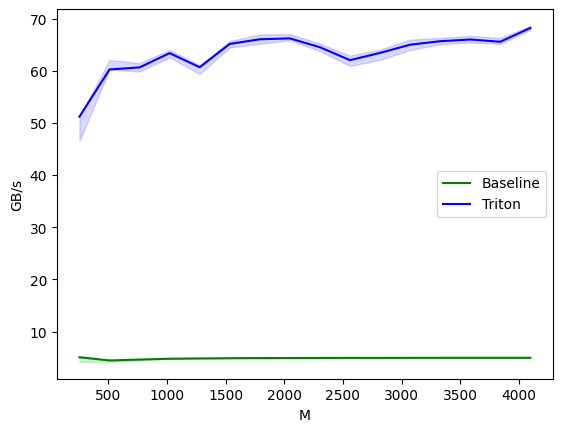

quant-rms-norm-forward:
         M       N  Baseline     Triton
0    256.0   256.0  5.094528  51.200001
1    512.0   512.0  4.481401  60.235293
2    768.0   768.0  4.654546  60.631582
3   1024.0  1024.0  4.806410  63.365723
4   1280.0  1280.0  4.866920  60.663505
5   1536.0  1536.0  4.911271  65.130742
6   1792.0  1792.0  4.937611  66.021051
7   2048.0  2048.0  4.951345  66.193802
8   2304.0  2304.0  4.962435  64.497667
9   2560.0  2560.0  4.972322  62.023016
10  2816.0  2816.0  4.967486  63.410441
11  3072.0  3072.0  4.981958  64.987218
12  3328.0  3328.0  4.983040  65.650985
13  3584.0  3584.0  4.987124  65.977644
14  3840.0  3840.0  4.982914  65.547653
15  4096.0  4096.0  4.991128  68.195631
Trial when M = 256 and N = 256 for baseline for backward pass
Trial when M = 256 and N = 256 for triton for backward pass
Triton autotuning for function quant_rms_norm_bwd_kernel finished after 0.72s; best config selected: num_warps: 1, num_ctas: 1, num_stages: 2, maxnreg: None;
Trial when M = 5

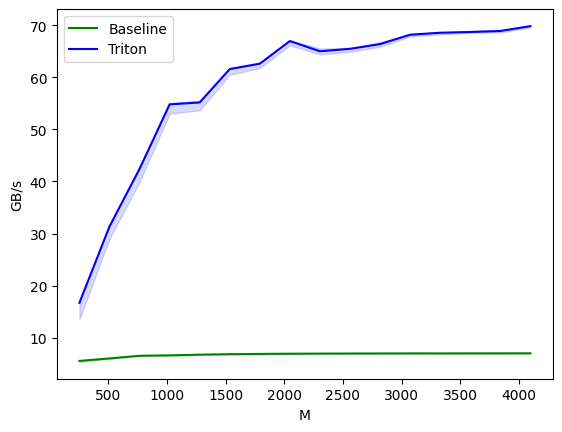

quant-rms-norm-backward:
         M       N  Baseline     Triton
0    256.0   256.0  5.525180  16.695652
1    512.0   512.0  6.000000  31.346940
2    768.0   768.0  6.514609  42.404907
3   1024.0  1024.0  6.592275  54.799805
4   1280.0  1280.0  6.727400  55.172414
5   1536.0  1536.0  6.815727  61.576836
6   1792.0  1792.0  6.869837  62.615643
7   2048.0  2048.0  6.906766  66.964578
8   2304.0  2304.0  6.926623  65.003134
9   2560.0  2560.0  6.943628  65.473148
10  2816.0  2816.0  6.952566  66.377145
11  3072.0  3072.0  6.970377  68.182490
12  3328.0  3328.0  6.965333  68.564185
13  3584.0  3584.0  6.974055  68.702878
14  3840.0  3840.0  6.979844  68.899521
15  4096.0  4096.0  6.985663  69.830583


In [23]:
# ruff: noqa: E731
@triton.testing.perf_report(configs)
def benchmark(M, N, provider, mode):
    print(f"Trial when M = {M} and N = {N} for {provider} for {mode} pass")
    x_shape = (M, N)
    weight_shape = (N,)

    x = torch.rand(x_shape, device="cuda", requires_grad=True)
    gain = torch.rand(weight_shape, device="cuda", requires_grad=True)
    bias = torch.rand(weight_shape, device="cuda", requires_grad=True)
    dy = 0.1 * torch.randn_like(x)

    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():
        if provider == "baseline":
            return quant_rms_norm_baseline(x, gain, bias, 1e-5)
        if provider == "triton":
            return quant_rms_norm_triton(x, gain, bias, 1e-5)

    if mode == "forward":
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles)
    else:  # Backward
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: y.backward(dy, retain_graph=True), quantiles=quantiles, grad_to_none=[x]
        )

    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)